# Clip DEM

### This notebook uses polygons drawn in Google Earth to clip Digital Elevaiton Model raster files.

### These DEMs cam be used ot derive plot scale topography, which can effect vine growth. 

At least, that's the thought.

Polygons are already included in the repository, but new ones can be added!. This workflow should work for any polygon of agricultural area.

In [1]:
import os
os.chdir("..")

### Define a funciton to open and parse the polygons drawn in Google Earth. Saving them as geojson allows us to quickly load them as a gdf using geopandas.

In [2]:
from lxml import etree 
from shapely.geometry import Polygon
import geopandas as gpd

def kml_to_geojson(file = 'data/polygons/RegressionRidge_smol.kml'):
    # parse KML
    tree = etree.parse(file)
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}

    # find all polygons
    polygons = tree.xpath('//kml:Polygon', namespaces=ns)

    # list to hold polygons
    geoms = []

    # iterate over polygons to grab individual plot geometries
    for poly in polygons:
        # grab text of individual polygons
        coords_text = poly.xpath('.//kml:coordinates', namespaces=ns)[0].text

        # parse string and convert to float
        coords = [(float(x), float(y)) for x,y, *_ in (c.split(',') for c in coords_text.strip().split())]
        geoms.append(Polygon(coords))

    # save geometries as a geopandas df
    gdf = gpd.GeoDataFrame(geometry=geoms)
    gdf.to_file('data/polygons/RegressionRidge_smol.geojson', driver='GeoJSON')

In [3]:
# convert kml to geoson
kml_to_geojson(file = 'data/polygons/RegressionRidge.kml')
kml_to_geojson(file = 'data/polygons/RegressionRidge_smol.kml')

In [4]:
# read the geojson to a df

vineyard = gpd.read_file('data/polygons/RegressionRidge.geojson')

plots = gpd.read_file('data/polygons/RegressionRidge_smol.geojson')

### find a DEM using the USGS public data source.

https://apps.nationalmap.gov/downloader/

Regression Ridge has a 1 meter resolution geotiff DEM, link defined below

In [5]:
dem_link = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/WA_ColumbiaValley_2018_D19/TIFF/USGS_1M_11_x28y509_WA_ColumbiaValley_2018_D19.tif'

In [6]:
import os
import requests
from tqdm import tqdm

# where to get the file
url = dem_link

# where to put the file
save_path = 'data/DEM/RegressionRidge_DEM_raw.tif'

# download the file
if os.path.exists(save_path):
    print(f'File already exists at {save_path}. Skipping download.')
else:
    print(f'Downloading file to {save_path}...')
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))  # Total file size in bytes

    block_size = 1024  # 1 KB
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

    with open(save_path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    progress_bar.close()

    if total_size != 0 and progress_bar.n != total_size:
        print('Download incomplete!')
    else:
        print('Download complete:', save_path)

File already exists at data/DEM/RegressionRidge_DEM_raw.tif. Skipping download.


In [7]:
import json
import rasterio
from rasterio.mask import mask


# set value for non-data
nodata_val = -9999
vineyard_utm = vineyard.to_crs("EPSG:26911")

# capture vineyard outline geometry
geoms = [json.loads(vineyard_utm.to_json())['features'][0]['geometry']]

# set path for dem
dem_path = 'data/DEM/RegressionRidge_DEM_raw.tif' 

# open dem.tif and clip according to vineyard geometry
with rasterio.open(dem_path) as src:
    # DEM metadata
    print('CRS:', src.crs)
    print('Bounds:', src.bounds)
    print('Resolution:', src.res)
    print('Min/Max:', src.read(1).min(), src.read(1).max())
    
    # mask and clip the DEM to the vineyard outline
    dem_clip, dem_transform = mask(src, geoms, crop=True, filled=True, nodata=nodata_val)
    dem_clip = dem_clip.astype('float32')  # convert to float
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # xmin, xmax, ymin, ymax
    crs = src.crs
    dem_meta = src.meta.copy()
    dem_meta.update({
        'driver': 'GTiff',
        'height': dem_clip.shape[1],
        'width': dem_clip.shape[2],
        'transform': dem_transform,
        'dtype': 'float32',
        'nodata':nodata_val
    })
    

# save the clipped DEM
with rasterio.open('data/DEM/RegressionRidge_DEM.tif', 'w', **dem_meta) as dest:
    dest.write(dem_clip)
    
    

CRS: EPSG:26911
Bounds: BoundingBox(left=279993.9996929795, bottom=5079993.999972992, right=290005.9996929795, top=5090005.999972992)
Resolution: (1.0, 1.0)
Min/Max: -999999.0 291.04285


In [8]:
# Reproject DEM to lat/lon
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# save dest for lat/lon projected dem
dem_latlon_path = 'data/DEM/RegressionRidge_DEM_latlon.tif'
# destination coordinate system for lat/lon
dst_crs = 'EPSG:4326'

with rasterio.open('data/DEM/RegressionRidge_DEM.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    dem_reproj = np.empty((src.count, height, width), dtype=src.dtypes[0])
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=dem_reproj[i-1],
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

    with rasterio.open(dem_latlon_path, 'w', **kwargs) as dst:
        dst.write(dem_reproj)

# reproject vineyard polygon back to lat/lon
vineyard_latlon = vineyard_utm.to_crs("EPSG:4326")


Nice, now we have a DEM clipped to the outline. Now let's visualize it with the smaller plot polygons.

First we have to do some projection book-keeping to make sure everything is aligned.

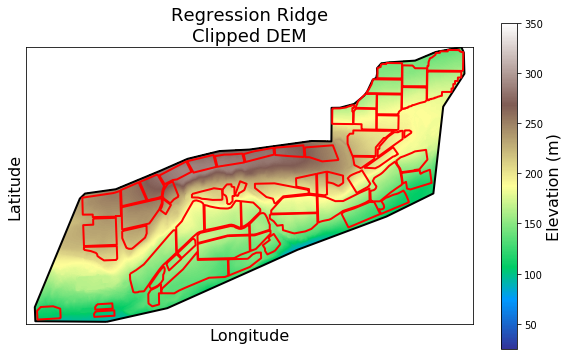

In [9]:
import matplotlib.pyplot as plt

with rasterio.open('data/DEM/RegressionRidge_DEM_latlon.tif') as src:
    dem = src.read(1, masked=True)  # auto-masks nodata values
    raster_crs = src.crs
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot DEM
im = ax.imshow(
    dem,
    extent=extent,
    origin='upper',
    cmap='terrain',
    vmin=25,
    vmax=350
)

# Add colorbar and set label/fontsize
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Elevation (m)', fontsize=16)

# Titles and axis labels
plt.title('Regression Ridge\nClipped DEM', fontsize=18)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)

# Hide ticks
plt.xticks([])
plt.yticks([])

# Overlay vineyard and subplots
vineyard.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2)
plots.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Subplots')


plt.savefig('img/dem_clip.png')